<a href="https://colab.research.google.com/github/michaelgadda/SVMFromScratch/blob/main/cleanSVMImplimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
import random as random
import math as math
from mpl_toolkits.mplot3d import Axes3D

# Creating Linearly Separable Dataset

In [11]:
separable = False
while not separable:
  samples = datasets.make_classification(n_samples=100, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, flip_y=0)

  red = samples[0][samples[1] == 0]
  blue = samples[0][samples[1] == 1]
  separable = any([red[:,k].max() < blue[:, k].min() or red[:, k].min() > blue[:, k].max() for k in range(2)])

# Making the data-set easy to work with for SVMs
Changing the 0 label to -1

In [12]:
#Lets set 0 to -1 for our classification
#rand_index = np.random.randint(0, len(samples[1]-1))
samples[1][samples[1] == 0] = -1


# My SVM Implimentation

https://cs229.stanford.edu/materials/smo.pdf

https://www.microsoft.com/en-us/research/uploads/prod/1998/04/sequential-minimal-optimization.pdf

In [6]:
class mySVM:
  def __init__(self):
    self._A = None
    self._w = []
    self._X = None
    self._Y = None
    self._E = []
    self._b = 0
    self._initialized = False
    self._C = 1
    self._eps = .001

  def fit(self, X, Y, C=1, eps=.001):
    if X[:,0].shape[0] != Y.shape[0]:
      print(f"Rows differ: X = {X.shape[0]} Y = {Y.shape[0]}")
      return
    else:
      self._A = np.zeros(Y.shape[0])
      self._w = np.zeros(X.shape[1])

      self._X = X
      self._Y = Y
      self._C = C
      self._eps = eps
      self._E = self._initialize_error_cache()
      self._initialized = True
      self._initialize_as()

  def _initialize_error_cache(self):
      E_C = []
      for i in range(self._Y.shape[0]):
        a = self._A[i]
        y = self._Y[i]
        x = self._X[i]
        p = 0
        E = p-y
        E_C.append(E)
      return E_C


  def _initialize_as(self):
      examineAll = True
      num_changed = 0
      max_passes = 500
      counter = 0
      while((num_changed > 0 or examineAll) and counter < max_passes):
        num_changed = 0
        non_converged_as = self._get_non_converged_as()
        if examineAll:
          for i2 in range(self._Y.shape[0]):
            non_converged_as = self._get_non_converged_as()
            num_changed += self._examineSample(i2, non_converged_as)
        else:
          for index in non_converged_as:
            num_changed += self._examineSample(index, non_converged_as)
        if examineAll == True:
          examineAll = False
        elif (num_changed == 0):
          examineAll = True
        counter += 1


  def _get_non_converged_as(self):
    non_converged_a_indexes = []
    for index, value in enumerate(self._A):
      if value != 0 and value != self._C:
        non_converged_a_indexes.append(index)
    return non_converged_a_indexes

  def _examineSample(self, i2, non_converged_As):
    new_A = self._A.copy()
    new_non_converged_As =  self._get_non_converged_as()
    p2 = self._A[i2]*self._Y[i2]*(self._X[i2].T @ self._X[i2]) + self._b
    E2 = p2-self._Y[i2]
    r2 = E2*self._Y[i2]
    i1 = 0
    if ((r2 < -self._eps and self._A[i2] < self._C) or (r2 > self._eps and self._A[i2] > 0)):
      if len(new_non_converged_As) > 1:
        i1 = new_non_converged_As[0]
        if self._take_step(i1, i2):
          return 1

      random.shuffle(new_non_converged_As)
      for index in new_non_converged_As:
        i1 = index
        if self._take_step(i1, i2):
          return 1
      A_indexes = list(range(len(self._A)))
      random.shuffle(A_indexes)
      for index in A_indexes:
        i1 = index
        if self._take_step(i1, i2):
          return 1
    return 0

  def _find_upper_lower_bounds(self, y1, y2, a1, a2):
    L,H = 0,0

    if y1 != y2:
      L = max(0, a2-a1)
      H = min(self._C, self._C + a2-a1)
    elif y1 == y2:
      L = max(0, a2+a1-self._C)
      H = min(self._C, a2+a1)

    return L, H


  def _objective_function(self, a1, a2, a2_new, i1, i2):
    y1 = self._Y[i1]
    y2 = self._Y[i2]
    x1 = self._X[i1]
    x2 = self._X[i2]
    k11 = np.dot(x1, x1)
    k12 = np.dot(x1, x2)
    k22 = np.dot(x2, x2)
    return a1 + a2_new - 0.5 * (a1**2 * k11 + a2_new**2 * k22 + 2 * a1 * a2_new * y1 * y2 * k12)


  def _update_error_cache(self, i, j, new_ai, new_aj):
      y_i = self._Y[i]
      x_i = self._X[i]
      y_j = self._Y[j]
      x_j = self._X[j]

      f_x = np.dot((self._A * self._Y), self._X @ self._X.T) + self._b

      self._E = f_x - self._Y


  def _take_step(self, i1, i2):
    if i1 == i2:
      return 0

    a1 = self._A[i1]
    a2 = self._A[i2]
    y1 = self._Y[i1]
    y2 = self._Y[i2]
    x1 = self._X[i1]
    x2 = self._X[i2]
    E1 = self._E[i1]
    E2 = self._E[i2]
    s = y1*y2
    L, H = self._find_upper_lower_bounds(y1, y2, a1, a2)
    if L == H:
      return 0

    kl11 = x1 @ x1
    kl12 = x1 @ x2
    kl22 = x2 @ x2
    eta =  kl11 + kl22 - 2*kl12

    if eta > 0:
      new_a2 = a2 + y2*(E1 - E2)/eta
      if (new_a2 < L):
        new_a2 = L
      elif (new_a2 > H):
        new_a2 = H
    else:
      return 0
      # Not including, returning back non-changed instead to choose next A
      # lObj = (y2*x2*L)@x2
      # hObj = (y2*x2*H)@x2
      # if (lObj < (hObj - self._eps)):
      #   new_a2 = L
      # elif (lObj > (hObj + self._eps)):
      #   new_a2 = H
      # else:
      #   new_a2 = a2

    if (abs(new_a2 - a2) < self._eps*(a2+new_a2+self._eps)):
      return 0
    new_a1 = a1 + s*(a2 - new_a2)
    self._A[i1] = new_a1
    self._A[i2] = new_a2
    self._b = self._calculate_b_threshold(i1, i2, new_a1, new_a2, a1, a2)
    self._update_error_cache(i1, i2, new_a1, new_a2)
    self._w = self._w + self._Y[i1]*(new_a1 - a1) * self._X[i1] + self._Y[i2]*(new_a2 - a2) * self._X[i2]
    return 1


  def get_weights(self):
    return self._w

  def get_bias(self):
    return self._b


  def predict(self, x):
    y = self._w.T @ x + self._b
    return y

  def _calculate_b_threshold(self, i, j, a_i_new, a_j_new, a_i_old, a_j_old):
    # My original implimentation of the threshold - did not work so implimented it in different direction
    # b1 =  self._E[i] + self._Y[i]*(a_i_new - a_i_old) * (self._X[i] @ self._X[i].T) + self._Y[j]*(a_j_new - a_j_old) * (self._X[i] @ self._X[j].T) + self._b
    # b2 =  self._E[j] + self._Y[i]*(a_i_new - a_i_old) * (self._X[i] @ self._X[j].T) + self._Y[j]*(a_j_new - a_j_old) * (self._X[j] @ self._X[j].T) + self._b
    b1 = self._b - self._E[i] - self._Y[i]*(a_i_new - a_i_old) * (self._X[i] @ self._X[i].T) - self._Y[j]*(a_j_new - a_j_old) * (self._X[i] @ self._X[j].T)
    b2 =  self._b - self._E[j] - self._Y[i]*(a_i_new - a_i_old) * (self._X[i] @ self._X[j].T) - self._Y[j]*(a_j_new - a_j_old) * (self._X[j] @ self._X[j].T)

    if a_i_new > 0 and a_i_new > self._C:
      return b1
    elif a_j_new > 0 and a_j_new < self._C:
      return b2
    else:
      return (b1 + b2)/2

# Testing my SVM implimentation against Sklearn's

In [13]:
#Implimented SVM
m_svm = mySVM()
#sklean's SVM
sk_svm = LinearSVC()

In [14]:
m_svm.fit(samples[0][:], samples[1][:])
sk_svm.fit(samples[0][:], samples[1][:])

LinearSVC()

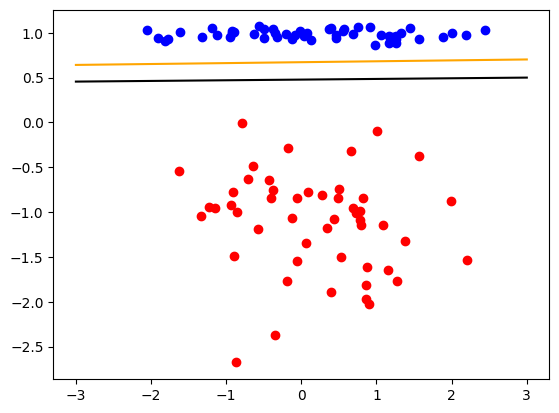

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(samples[0][:,0][samples[1][:] == -1], samples[0][:,1][samples[1][:] == -1], c = 'red')
ax.scatter(samples[0][:,0][samples[1][:] == 1], samples[0][:,1][samples[1][:] == 1], c = 'blue')
i=0       # intercept
s1= m_svm.get_weights()[0] / m_svm.get_weights()[1]    # slope
s2 = sk_svm.coef_[0][0] / sk_svm.coef_[0][1]
x=np.linspace(-3,3,6)
plt.plot(x, s1*x  - m_svm.get_bias(), c = 'orange')
plt.plot(x, s2*x  - sk_svm.intercept_, c = 'black')
plt.show()

# Further research and questions for YOU

I do believe there is something wrong with my implimentation, something minor. After many hours attempting to figure out what it was, I could not find an error. But maybe you can. Try this code out yourself and see if you can find whats wrong or what you can improve!